Задача про титаник:

взять подготовленные раннее данные из задачи Titanic, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр grid в GridSearchCV )
определить самые важные фичи
вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
for data in [train, test]:
    data['FamilySize'] = data['SibSp'] + data['Parch']
    data['IsAlone'] = 0 
    data['IsAlone'].loc[(data['FamilySize'] >= 1)] = 1

    data['FamilyCount']= 0
    data['FamilyCount'].loc[(data['FamilySize'] >= 1) & (data['FamilySize'] < 4)] = 1
    data['FamilyCount'].loc[data['FamilySize'] >= 5] = 2

    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
train.groupby('Sex')['Pclass'].value_counts(normalize=True)

Sex     Pclass
female  3         0.458599
        1         0.299363
        2         0.242038
male    3         0.601386
        1         0.211438
        2         0.187175
Name: Pclass, dtype: float64

In [6]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

train['is_test'] = 0
test['is_test'] = 1

In [7]:
df = pd.concat([train, test])

In [8]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

In [9]:
df_titanic = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [10]:
X_train = df_titanic[df_titanic.is_test==0].drop('is_test', axis=1)
X_test = df_titanic[df_titanic.is_test==1].drop('is_test', axis=1)

In [11]:
columns = X_train.columns

In [12]:
X_train.head(10)

,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FamilyCount,Title,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,1,1,1,1,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,1,1,3,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,2,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,1,1,3,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,0,0,1,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,0,0,0,1,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,0,0,0,1,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,4,1,0,4,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,2,1,1,3,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,1,1,1,3,0,0,1,0,1,0,0


Обработаем пустые значения

In [13]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [14]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imputer.fit(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [15]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [16]:
scaler = StandardScaler()
scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [18]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

In [19]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)

In [20]:
max_deep = np.linspace(1,10,10)
min_samples_leaf= [0.3,.5, 1, 2, 3, 4, 5, 7, 10]
criterion = ['gini','entropy']

In [21]:
grid = {'max_depth': max_deep,
        'criterion': criterion,
        'min_samples_leaf': min_samples_leaf
       }
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy', cv=5)

In [22]:
%%time
gridsearch.fit(X_train_fin, y_train_fin)

Wall time: 2.28 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [0.3, 0.5, 1, 2, 3, 4, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
gridsearch.best_params_

{'criterion': 'gini', 'max_depth': 6.0, 'min_samples_leaf': 2}

In [24]:
best_creterion= gridsearch.best_params_['criterion']
best_max_depth= gridsearch.best_params_['max_depth']
best_min_samples_leaf = gridsearch.best_params_['min_samples_leaf']

In [25]:
clf = DecisionTreeClassifier(criterion= best_creterion, max_depth=best_max_depth, min_samples_leaf= best_min_samples_leaf, random_state=2019)
clf.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2019,
            splitter='best')

In [26]:
y_val_pred = clf.predict(X_val)

In [27]:
accuracy_score(y_val, y_val_pred)

0.8659217877094972

In [28]:
clf.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2019,
            splitter='best')

([<matplotlib.axis.YTick at 0x15dac0355f8>,
 <a list of 15 Text yticklabel objects>)

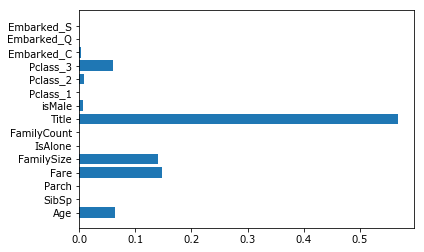

In [29]:
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X_train_imputed_scaled.columns)),X_train_imputed_scaled.columns)

In [30]:
clf.predict_proba(X_test_imputed_scaled)[:10]

array([[1.        , 0.        ],
       [0.45977011, 0.54022989],
       [0.88571429, 0.11428571],
       [0.9027027 , 0.0972973 ],
       [0.45977011, 0.54022989],
       [0.9027027 , 0.0972973 ],
       [0.45977011, 0.54022989],
       [1.        , 0.        ],
       [0.45977011, 0.54022989],
       [0.96153846, 0.03846154]])

In [31]:
predictions = clf.predict(X_test_imputed_scaled)
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [32]:
submission = 'PassengerId,Survived\n'
submission += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])
with open('submission.txt', 'w') as file:
    file.write(submission)

Lvl 2: (опционально)

С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) @NikitaKuznetsov

In [33]:
from sklearn import metrics

In [34]:
def metrics_roc(y, y_pred):
    accuracy= metrics.accuracy_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    cf_mtrx = metrics.confusion_matrix(y, y_pred)
    TPR = [0, recall, 1]
    pr_metrics = [0, precision, 1]
    FPR = cf_mtrx[0][1]/(cf_mtrx[0][1]+cf_mtrx[1][1])
    FPR = [0, FPR, 1]
    ROC_AUC = metrics.auc(FPR, TPR)
    ROC_PRC = metrics.auc(pr_metrics, TPR)
    return ROC_AUC, ROC_PRC

In [35]:
ROC_AUC, ROC_PRC = metrics_roc(y_val, y_val_pred)

In [36]:
print('ROC_PRC {:f}'.format(ROC_PRC), ' ROC_AUC {:f}'.format(ROC_AUC))

ROC_PRC 0.411159  ROC_AUC 0.824952
